# Objectives

1. Plot RTT: Regression
1. Plot Rate Variation: Histogram
1. Plot Timetree: Phylo
1. Plot Divtree: Phylo
1. Plot Marginal Distribution: Violin

---
# Setup

## Import Modules

In [1]:
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

import dill
from treetime.treetime import plot_vs_years

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "clock"
PREV_SCRIPT_NAME = "clock_model"

WILDCARDS = snakemake.wildcards
# TESTING  WILDCARDS = ["all", "chromosome", "50"]
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

sns.set_style("ticks")

## Input File Paths

In [3]:
project_dir = os.getcwd()
# TESTING project_dir = os.path.dirname(os.path.dirname(project_dir))
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")


outdir       = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_plot"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50/clock_model_timetree.treetime.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50/clock_model.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter50.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50


## Import Dataframe

In [4]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,2.148815e-07,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.942141e-08,1.000000,2.148815e-07,0855-09-28,855.740923,"[855.7409234792349, 855.7409234792349]","[1165.2590765207651, 1165.2590765207651]",0.100000,0.100000,2.25,855.740923,0.000000,False
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,2.278202e-05,1.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,2.052208e-08,1.056673,2.256714e-05,1938-03-30,1938.242634,"[1923.0, 1923.0]","[98.0, 98.0]",1082.501711,1082.601711,1.00,1923.000000,0.000023,False
Reference,NA,NA,2.307300e-05,grey,2.149205e-05,2.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,1.821491e-08,0.937878,2.127716e-05,1996-07-12,1996.529295,"[1992.0, 1992.0]","[29.0, 29.0]",1140.788371,1140.888371,2.00,1992.000000,0.000021,False
NODE1,91,0,2.721210e-05,black,2.536025e-05,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.136642e-08,1.100148,2.514537e-05,2005-09-05,2005.678813,"[1985.457689492314, 2005.0]","[35.5423105076859, 16.0]",1149.937889,1150.037889,3.50,2005.678813,0.000025,False
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,2.536025e-05,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,5.812589e-09,0.299288,2.828252e-18,2008-05-10,2008.355574,"[2006.0, 2006.0]","[15.0, 15.0]",2.676761,1152.714650,3.00,2006.000000,0.000025,False
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,2.557514e-05,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,3.247561e-08,1.672155,2.148899e-07,2007-07-06,2007.510839,"[2005.0, 2005.0]","[16.0, 16.0]",1.832026,1151.869916,4.00,2005.000000,0.000025,False


## Import Tree

In [5]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

In [6]:
tt.clock_model

{'slope': 1.942140670161841e-08,
 'intercept': -1.513937770593477e-05,
 'chisq': 0.43127195995761375,
 'hessian': array([[1.39341357e+18, 7.04885552e+14],
        [7.04885552e+14, 3.56697216e+11]]),
 'cov': array([[ 2.18698558e-15, -4.32180143e-12],
        [-4.32180143e-12,  8.54331138e-09]]),
 'r_val': 0.4871569731892144,
 'valid_confidence': True}

---
# 1. Plot RTT: Regression

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


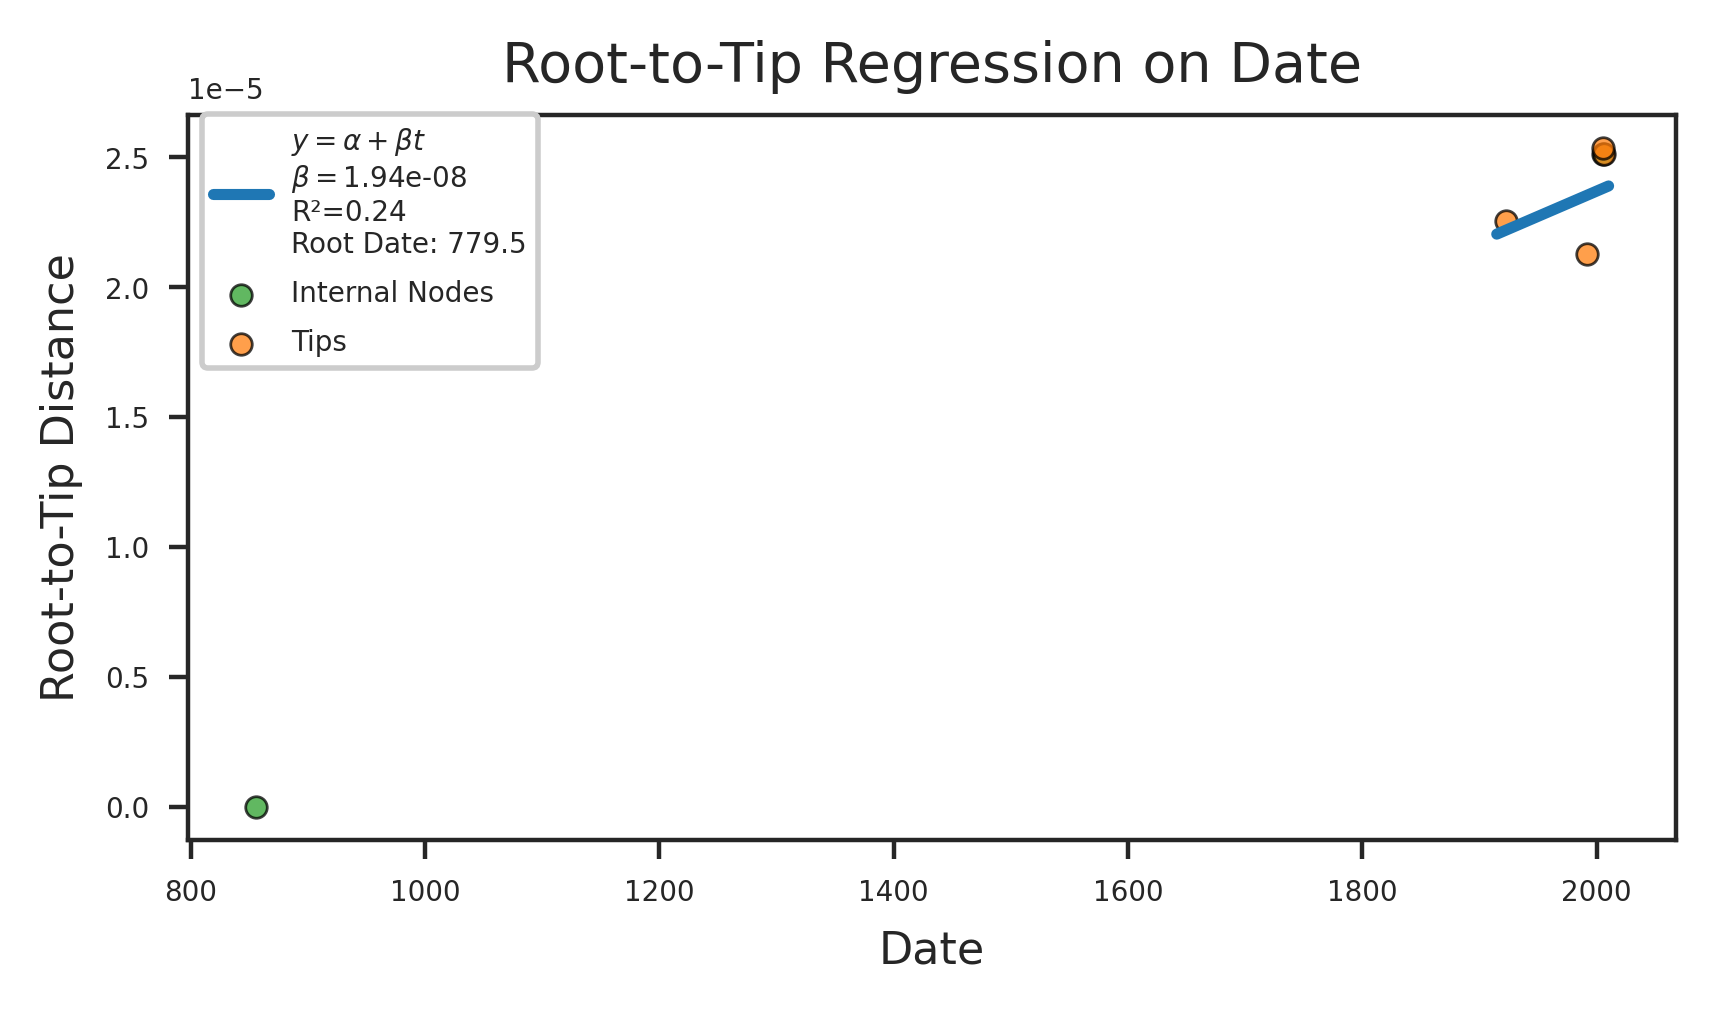

In [7]:
regression = tt.clock_model

# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.2f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
#plt.legend(loc=2, frameon = 1, framealpha=1)
plt.legend(bbox_to_anchor=(0,1.02), 
           loc="upper left",
           frameon = 1, 
           framealpha=1)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation: Histogram

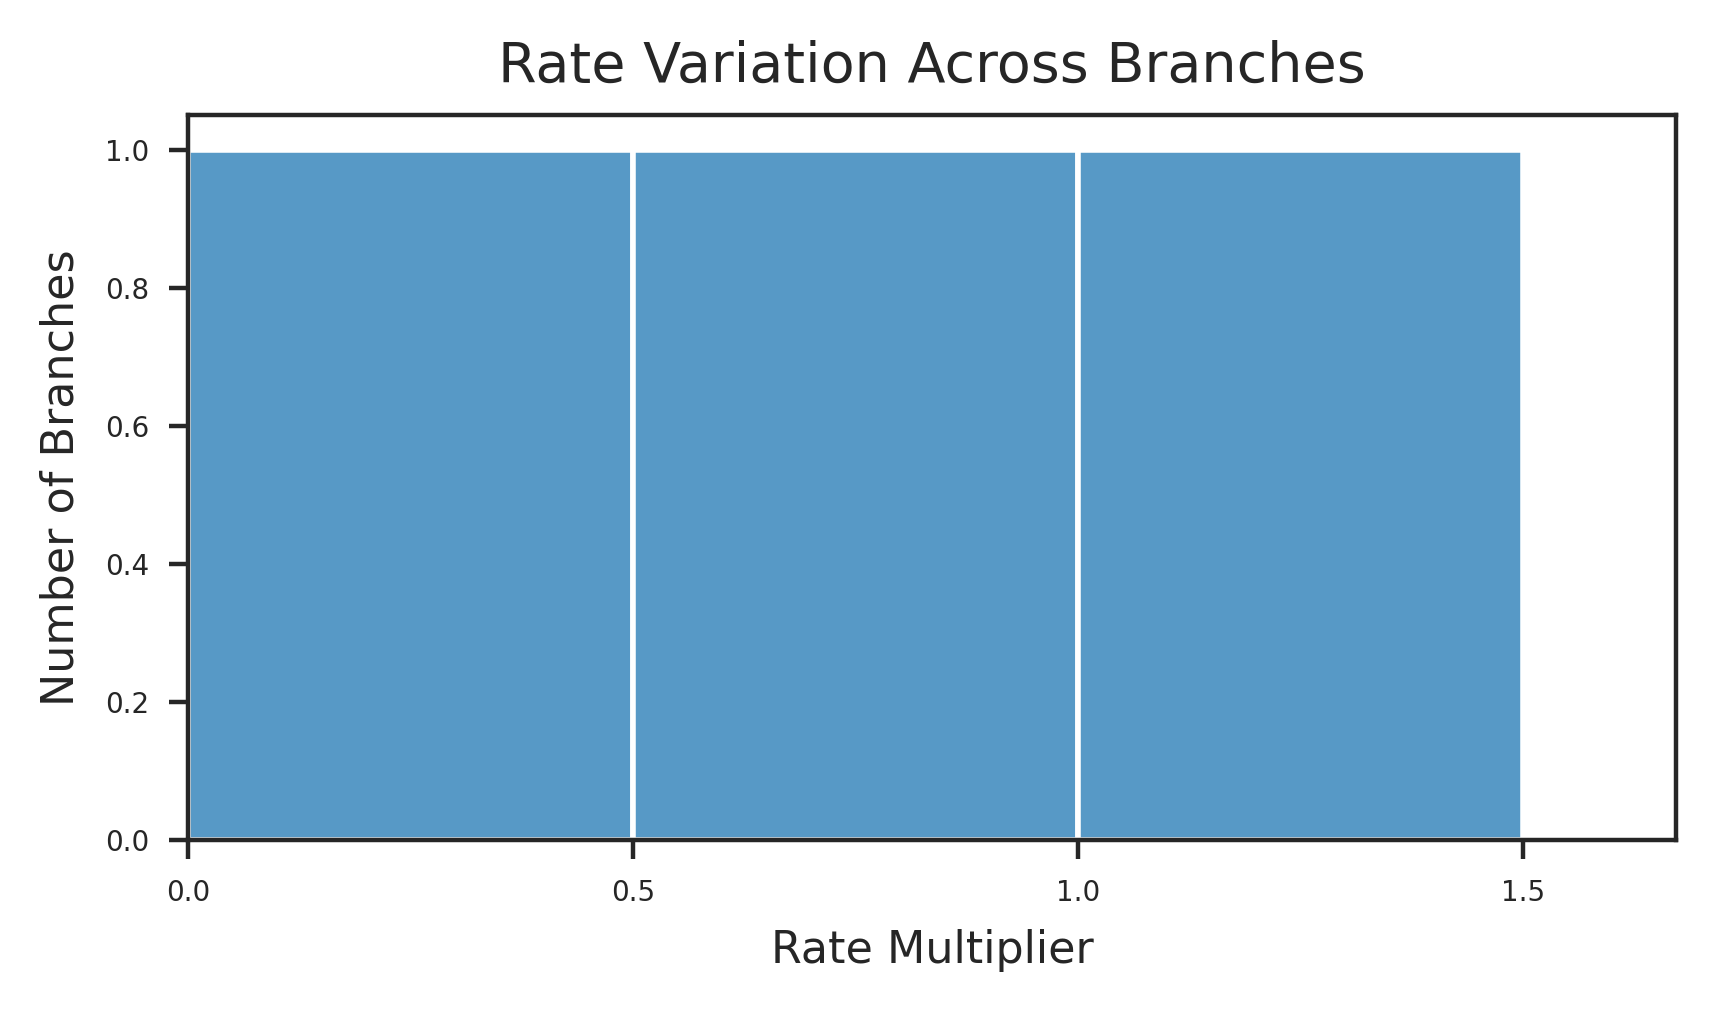

In [8]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the histogram
# troubleshoot the disappearing nodes!

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}
    
for rec in tip_data.iterrows():
    sample = rec[0]
    data = rec[1]
    g = tip_data["timetree_rate_fold_change"][sample]
    if g <= min_gamma[1]:
        min_gamma[0] = sample
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = sample
        max_gamma[1] = g
    gamma_dict[sample] = g

# Check if there's no rate variation
if min_gamma[1] == 1 and max_gamma[1] == 1:
    hist_bins=1
    ax1.set_xticks([1.0])
else:
    int_max_gamma = math.ceil(max_gamma[1])
    hist_bins = [x/10 for x in range(0,int_max_gamma * 10, 5)]
    xticks_major = [x/10 for x in range(0, int_max_gamma * 10, 5)]
    ax1.set_xticks(xticks_major)
    ax1.set_xlim(0,max_gamma[1])

sns.histplot(x = list(gamma_dict.values()), 
         ax=ax1,
         alpha=0.75,
         bins=hist_bins,
         ) 

ax1.set_xlabel("Rate Multiplier")
ax1.set_ylabel("Number of Branches")
ax1.set_title("Rate Variation Across Branches")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate-variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")

# 3. Plot Timetree: Phylo

1133.54	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


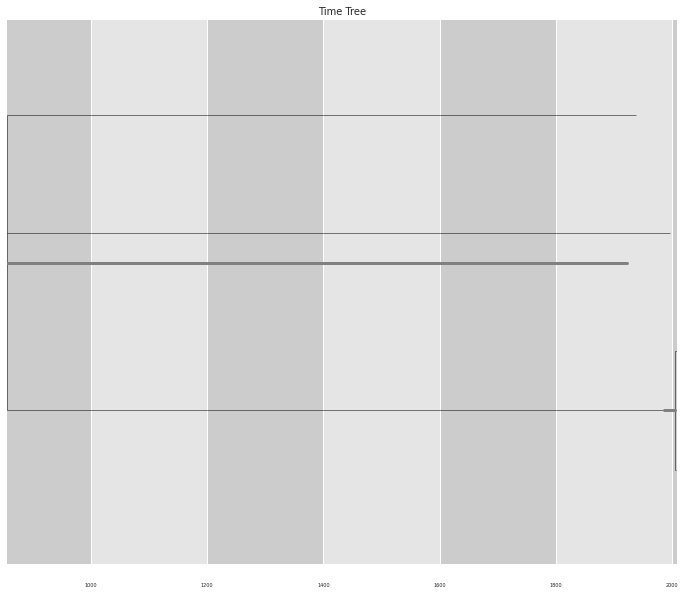

In [9]:
tt_copy = copy.deepcopy(tt)

# Setup plot
plt.rc("lines", linewidth=0.5)
#DIV = 10
#STEP = (CURRENT_YEAR - tt_copy.tree.root.numdate) / DIV
#STEP = round(STEP, -3)

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = plot_vs_years(tt_copy,
                             show_confidence=False,
                             confidence=(1.0-CONFIDENCE,CONFIDENCE), 
                             label_func = lambda x:"",
                             do_show=False)
else:
    fig, ax1 = plot_vs_years(tt_copy,
                             show_confidence=False,                             
                             label_func = lambda x:"",
                             do_show=False)

ax1.set_title("Time Tree", fontsize=LG_FONT)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-default." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")


## Manual

1134.02	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


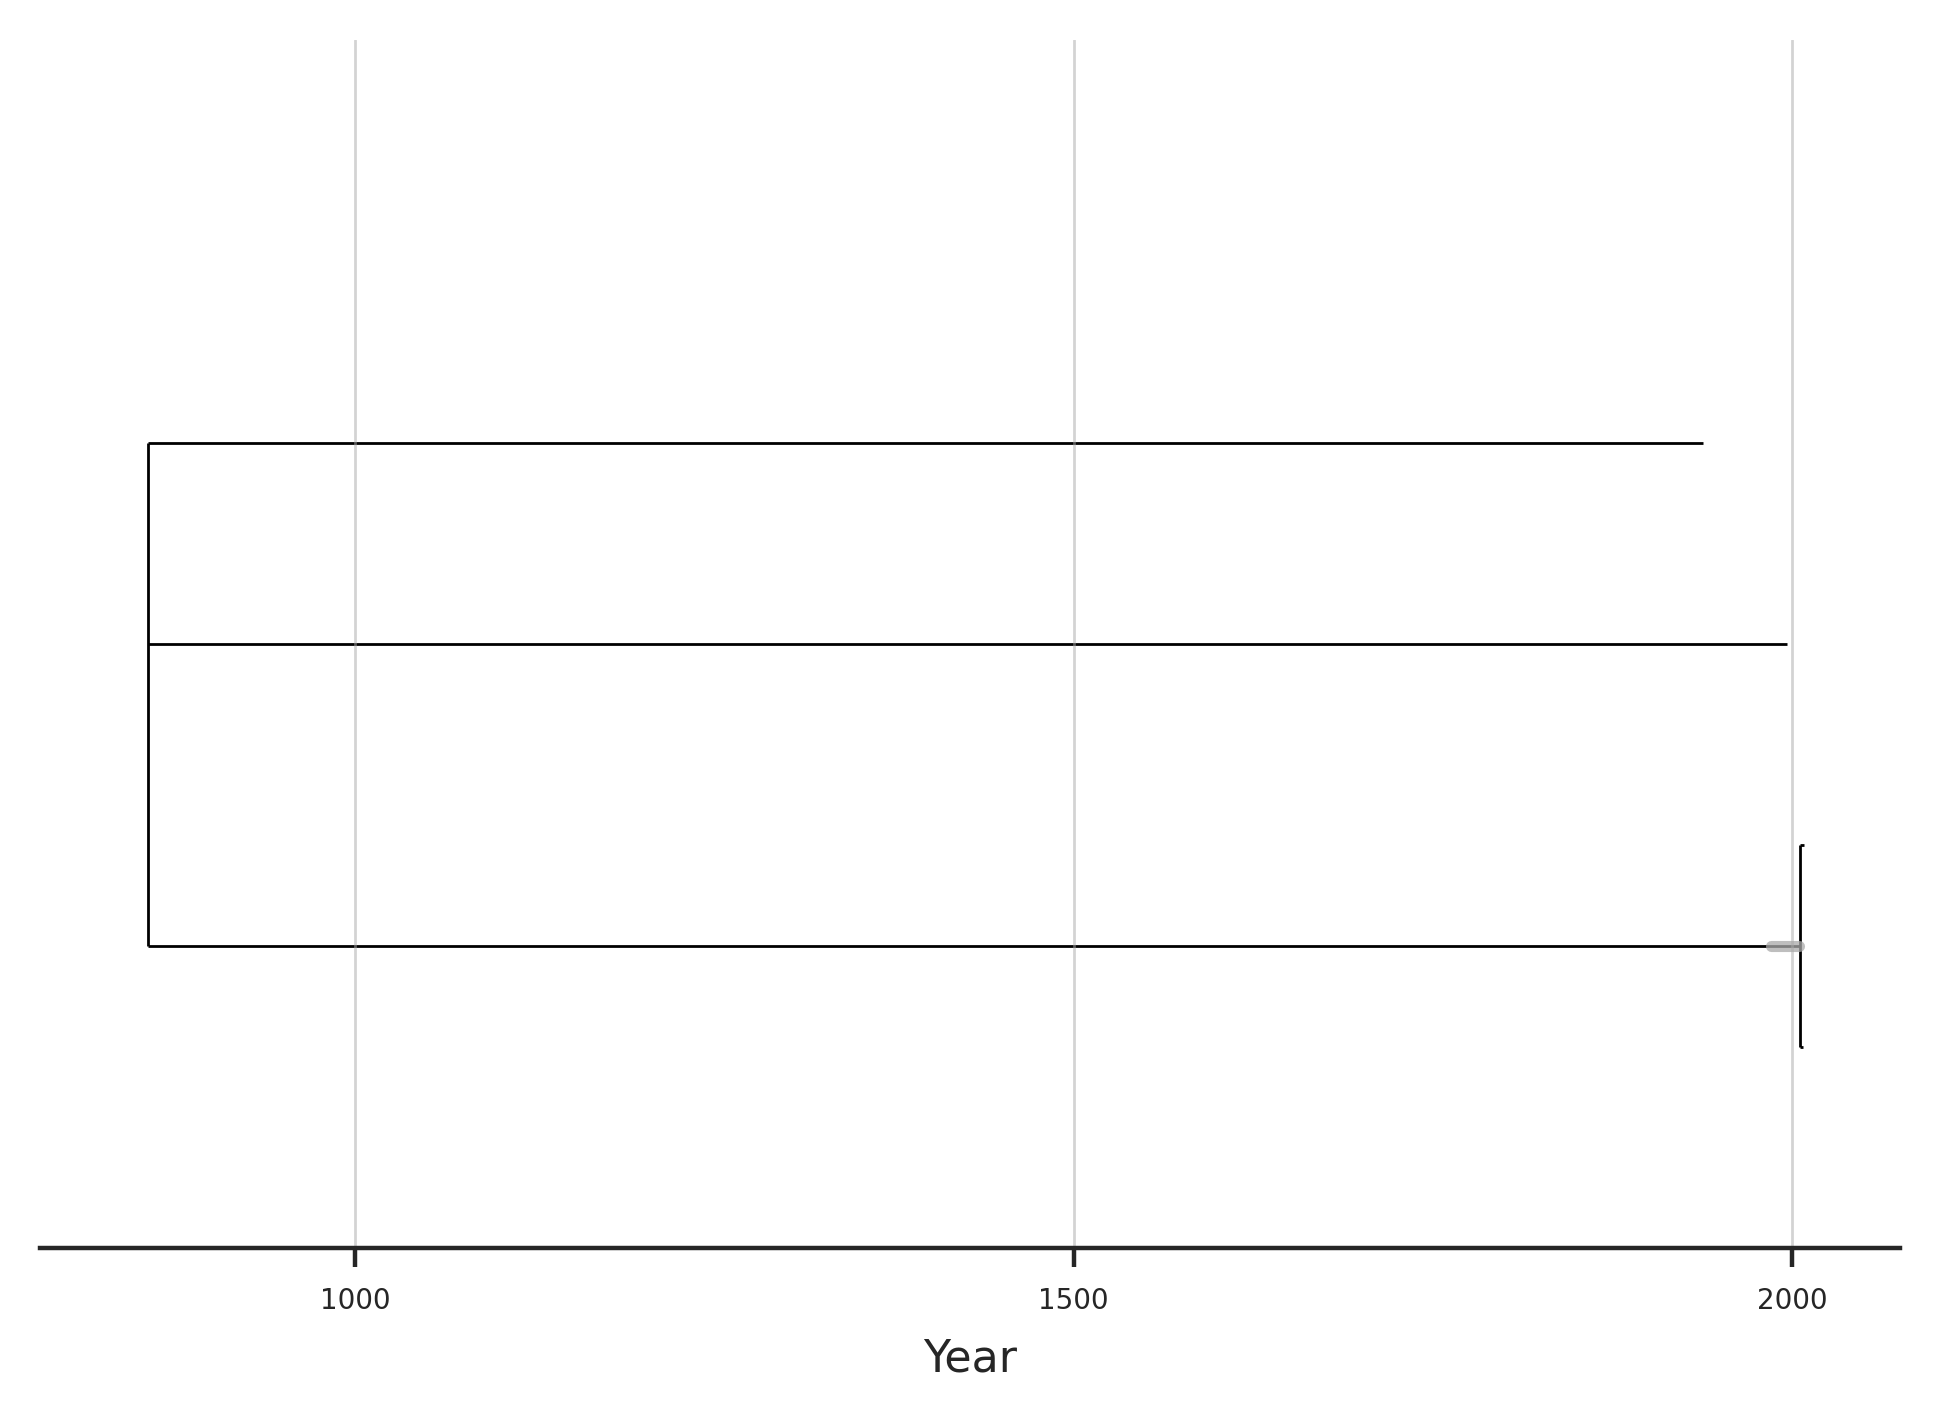

In [10]:
# --------------------------------------------
# Setup
plt.rc("lines", linewidth=0.25)
fig, ax1 = plt.subplots(1, dpi=dpi)

# --------------------------------------------
# Data
tt_copy.branch_length_to_years()

# reset color
for c in tt_copy.tree.find_clades():
    c.color = "black"
    
plt.rc("lines", linewidth=0.5)
Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)


# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
ax1.set_xticks(ticks_dict["tick_locs"])
ax1.set_xticklabels(ticks_dict["tick_labels"])
date_to_x = float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1])

x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.75, c="darkgrey", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower
        

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")
ax1.set_yticks([])
#plt.title("Time Tree")

# --------------------------------------------
# Limits
x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

#ax1.set_xlim(ticks_dict["tick_locs"][0], ticks_dict["tick_locs"][-1] + x_buffer)
ax1.set_xlim(x_min - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# 4. Plot Rate Variation

In [11]:
"""# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
min_gamma = min(tree_df["timetree_rate_fold_change"])
max_gamma = max(tree_df["timetree_rate_fold_change"])
gamma_range = max_gamma - min_gamma

GAMMA_COL_PAL = {
    0: "#000000", # black
    1: "#facb35", # yellow
    2: "#ff8800", # orange
    3: "#ff0000"} # red

for c in tt_copy.tree.find_clades():
    if not hasattr(c.branch_length_interpolator, "gamma"):
        c.color = GAMMA_COL_PAL[0]
        continue
    gamma = c.branch_length_interpolator.gamma
    # Switch Case
    if gamma >= 0 and gamma < 1:
        c.color = GAMMA_COL_PAL[0]
    elif gamma >= 1 and gamma < 2:
        c.color = GAMMA_COL_PAL[1]    
    elif gamma >= 2 and gamma < 3:
        c.color = GAMMA_COL_PAL[2]     
    elif gamma >= 3:
        c.color = GAMMA_COL_PAL[3] 

# Setup plot
plt.rc("lines", linewidth=1)
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Branch Length")
ax1.set_ylabel("")
ax1.set_yticks([])
plt.title("Divergence Tree")

# --------------------------------------------
# Limits
coord_x = [x for x in tree_df["coord_x"] if x != NO_DATA_CHAR]
x_buffer = max(coord_x) * 0.05
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(coord_x) + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-rate." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")"""

'# Set branch length to mutations\nfor n in tt_copy.tree.find_clades():\n    n.branch_length=n.mutation_length\n    \nmin_gamma = min(tree_df["timetree_rate_fold_change"])\nmax_gamma = max(tree_df["timetree_rate_fold_change"])\ngamma_range = max_gamma - min_gamma\n\nGAMMA_COL_PAL = {\n    0: "#000000", # black\n    1: "#facb35", # yellow\n    2: "#ff8800", # orange\n    3: "#ff0000"} # red\n\nfor c in tt_copy.tree.find_clades():\n    if not hasattr(c.branch_length_interpolator, "gamma"):\n        c.color = GAMMA_COL_PAL[0]\n        continue\n    gamma = c.branch_length_interpolator.gamma\n    # Switch Case\n    if gamma >= 0 and gamma < 1:\n        c.color = GAMMA_COL_PAL[0]\n    elif gamma >= 1 and gamma < 2:\n        c.color = GAMMA_COL_PAL[1]    \n    elif gamma >= 2 and gamma < 3:\n        c.color = GAMMA_COL_PAL[2]     \n    elif gamma >= 3:\n        c.color = GAMMA_COL_PAL[3] \n\n# Setup plot\nplt.rc("lines", linewidth=1)\nfig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, cons